In [1]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np
import pickle 

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

Define the model. The 4 reaction coefficients are the parameters.

In [2]:
rates = np.array([0.04,0.4,0.4,0.004,0.12,0.8765,0.01,0.01,0.01])

r1m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'S+I->E+I', 'c1', params = ['c1'])
r2m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'E->I', 'c2', params = ['c2'])
r3m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'I->Q', 'c3', params = ['c3'])
r4m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'I->', 'c4', params = ['c4'])
r5m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'I->R', rates[4], params = [])
r6m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'Q->R', rates[5], params = [])
r7m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'I->S', rates[6], params = [])
r8m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'Q->S', rates[7], params = [])
r9m = TTCME.ChemicalReaction(['S','E','I','Q','R'],'->S',  rates[8], params = [])

r1 = TTCME.ChemicalReaction(['S','E','I','Q','R'],'S+I->E+I', rates[0], params = [])
r2 = TTCME.ChemicalReaction(['S','E','I','Q','R'],'E->I', rates[1], params = [])
r3 = TTCME.ChemicalReaction(['S','E','I','Q','R'],'I->Q', rates[2], params = [])
r4 = TTCME.ChemicalReaction(['S','E','I','Q','R'],'I->',  rates[3], params = [])

mdl = TTCME.ReactionSystem(['S','E','I','Q','R'],[r1m, r2m, r3m, r4m, r5m, r6m, r7m, r8m, r9m], params= ['c1','c2','c3','c4'])
mdl_true = TTCME.ReactionSystem(['S','E','I','Q','R'],[r1, r2, r3, r4, r5m, r6m, r7m, r8m, r9m], params= [])

IC = [90,0,4,0,0]
N = [128,64,64,32,32] # state truncation

Generate the measurements and the time grid discretization.

In [3]:
No = 45
Tend = 5
time_observation = np.linspace(0, Tend, No+1)
dT = time_observation[1]-time_observation[0]

sigmas = [0.1,0.1,0.1,0.01,0.01]

np.random.seed(13212)
reaction_time,reaction_jumps,reaction_indices = mdl_true.ssa_single(IC, time_observation)
observations = mdl_true.jump_process_to_states(time_observation, reaction_time, reaction_jumps)
observations_noise = TTCME.pdf.LogNormalObservation.add_noise(observations, sigmas)


Plot the observations and the true trajectory.

Text(0, 0.5, '#individuals')

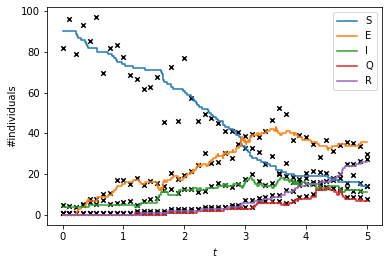

In [4]:
plt.figure()
for i in range(5): plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,i],2)[:-1])
for i in range(5): plt.scatter(time_observation,observations_noise[:,i],c='k', marker='x',s=20)
plt.legend(['S','E','I','Q','R'])
plt.xlabel(r'$t$')
plt.ylabel(r'#individuals')
# import tikzplotlib
# tikzplotlib.save('seiqr_trajectory.tex')

Define the basis of the parameter space.

In [5]:
Nl = 64
mult = 5
param_range = [[0,rc*mult] for rc in rates[:4]]
basis_param = [TTCME.basis.BSplineBasis(Nl,[p[0],p[1]],deg = 2) for p in param_range]

Define the prior distribution (independent gamma).

In [6]:
mu = rates[:4]*np.array([1.5,1.5,1.5,1.0])
var = rates[:4] * np.array([0.025, 0.1, 0.25, 0.0001])
alpha_prior = mu**2/var
beta_prior = mu/var
prior = TTCME.GammaPDF(alpha_prior, beta_prior, basis_param, ['c1','c2','c3','c4'])


Define the initial condition and the joint PDF.

In [7]:
p_ic = TTCME.pdf.SingularPMF(N,IC,['S','E', 'I', 'Q', 'R'])
p0 = p_ic ** prior
p0.normalize()

p = p0.dofs.clone()

print(p0)

Probability density function:
p(S,E,I,Q,R,c1,c2,c3,c4)

Basis:
Dirac-deltas basis defined on {0, 127} and dimension 128
Dirac-deltas basis defined on {0, 63} and dimension 64
Dirac-deltas basis defined on {0, 63} and dimension 64
Dirac-deltas basis defined on {0, 31} and dimension 32
Dirac-deltas basis defined on {0, 31} and dimension 32
B-spline basis defined on [0, 0.2] and dimension 64
B-spline basis defined on [0, 2.0] and dimension 64
B-spline basis defined on [0, 2.0] and dimension 64
B-spline basis defined on [0, 0.02] and dimension 64

DoF:
TT with sizes and ranks:
N = [128, 64, 64, 32, 32, 64, 64, 64, 64]
R = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 576 compression 6.394884621840902e-14



Instantiate the observation operator.

In [8]:
obs_operator = TTCME.pdf.LogNormalObservation(N, sigmas)

Compute the CME operator for the parameter dependent case.

In [9]:
Stt,Mtt,Mtt_inv = mdl.generator_tt_galerkin(N, basis_param)
Att = Mtt_inv @ Stt

Instantiate the TT time-domain solver. If the `qtt` flag is `True`, the result will be performed in the QTT format.

In [10]:
if qtt:
    A_qtt = Att.to_qtt()
    fwd_int = TTCME.TimeIntegrator.TTInt(A_qtt, epsilon = 1e-5, N_max = 8, dt_max = 1.0,method='cheby')
    Nbs = 1
    p = p.to_qtt()
else:
    fwd_int = TTCME.TimeIntegrator.TTInt(Att, epsilon = 1e-5, N_max = 64, dt_max = 1.0,method='crank–nicolson')
    Nbs = 1

Perform the perameter inference.

In [11]:
posterior_list  =[]
joint_pdf = p0.copy()
for i in range(1,No):
    
    y = observations_noise[i,:]

    
    po = obs_operator.likelihood(y) 
    #po = po / po.sum()
    
    po = po ** tntt.ones([Nl]*4)

    if qtt: po = po.to_qtt()
    
    print('new observation ',i,'/',No,' at time ',time_observation[i],' ',y)
    
    tme = datetime.datetime.now()
    p = fwd_int.solve(p, dT, intervals = Nbs,qtt = qtt,verb = False, rounding=True, device = None)
    tme = datetime.datetime.now() - tme
    
    
    print('\tmax rank ',max(p.R))
    p_pred = p
    p_post = po * p_pred
    p_post = p_post.round(1e-10)
    print('\tmax rank (after observation) ',max(p_post.R))
    
    if qtt:
        joint_pdf.dofs = tntt.reshape(p_post,joint_pdf.dofs.N)
        Z = joint_pdf.Z
        joint_pdf.normalize()
        p = p_post / Z
    else:
        joint_pdf.dofs = p_post.clone()
        joint_pdf.normalize()
        p = joint_pdf.dofs.clone()

    
    posterior_pdf = joint_pdf.marginal([0,1,2,3,4])
    posterior_pdf.round(1e-10)
    posterior_list.append(posterior_pdf.copy())



    E = posterior_pdf.expected_value()
    
    print('\tExpected value computed posterior ' ,E)
    # print('\tVariance computed posterior       ' ,V)
    print('\tposterior size ',tntt.numel(p)*8 / 1000000,' MB')
    print('\telapsed ',tme)

new observation  1 / 45  at time  0.1111111111111111   [96.31185677  0.97501919  4.4500247   0.99733794  1.00362629]


/home/yonnss/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


	max rank  110
	max rank (after observation)  81
	Expected value computed posterior  [tensor(0.0360), tensor(0.6001), tensor(0.5577), tensor(0.0040)]
	posterior size  0.780096  MB
	elapsed  0:00:32.236912
new observation  2 / 45  at time  0.2222222222222222   [79.02343153  1.17845123  4.06086264  0.99620622  1.00194543]
	max rank  109
	max rank (after observation)  101
	Expected value computed posterior  [tensor(0.0260), tensor(0.6001), tensor(0.5238), tensor(0.0040)]
	posterior size  1.177824  MB
	elapsed  0:00:19.356769
new observation  3 / 45  at time  0.3333333333333333   [93.32216716  5.14233296  4.75366078  0.98348485  1.01707931]
	max rank  124
	max rank (after observation)  124
	Expected value computed posterior  [tensor(0.0425), tensor(0.5921), tensor(0.4913), tensor(0.0040)]
	posterior size  1.851136  MB
	elapsed  0:00:13.147219
new observation  4 / 45  at time  0.4444444444444444   [85.29797055  7.75854551  6.16367466  1.00630144  1.01657533]
	max rank  163
	max rank (after 


Exact rates:                       [0.04   0.4    0.4    0.004  0.12   0.8765 0.01   0.01   0.01  ]

Expected value computed posterior  [tensor(0.0364), tensor(0.3740), tensor(0.4777), tensor(0.0040)]
Variance computed posterior        [1.69412082e-05 2.88054435e-03 9.51440181e-03 4.00682541e-07]

Expected value prior               [0.06  0.6   0.6   0.004]
Variance computed prior            [1.e-03 4.e-02 1.e-01 4.e-07]



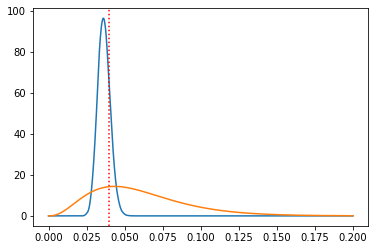

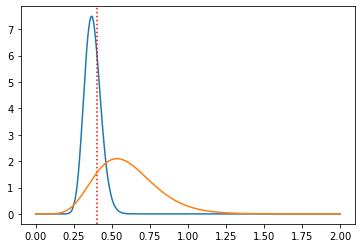

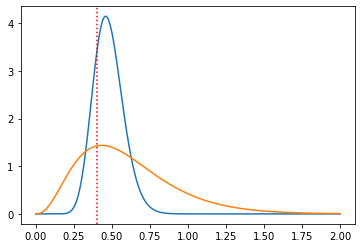

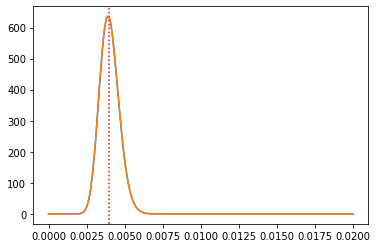

In [14]:
posterior_pdf.normalize()

E = posterior_pdf.expected_value()
C = posterior_pdf.covariance_matrix()
V = np.diag(C)

print()
print('Exact rates:                      ',rates)
print('')
print('Expected value computed posterior ' ,E)
print('Variance computed posterior       ' ,V)
# print('Computed modes:                   ',theta_mode)
print('')
print('Expected value prior              ' ,alpha_prior/beta_prior)
print('Variance computed prior           ' ,alpha_prior/beta_prior/beta_prior)
print('')


post_1 = posterior_pdf.marginal([1,2,3])
post_2 = posterior_pdf.marginal([0,2,3])
post_3 = posterior_pdf.marginal([0,1,3])
post_4 = posterior_pdf.marginal([0,1,2])


for i in range(4):
    pr = prior.marginal([j for j in range(4) if i!=j])
    po = posterior_pdf.marginal([j for j in range(4) if i!=j])
    x = np.linspace(param_range[i][0],param_range[i][1],1000)
    
    
    plt.figure()
    plt.plot(x, po[x].numpy())
    plt.axvline(rates[i],c='r',linestyle=':')
    plt.plot(x, pr[x].numpy())

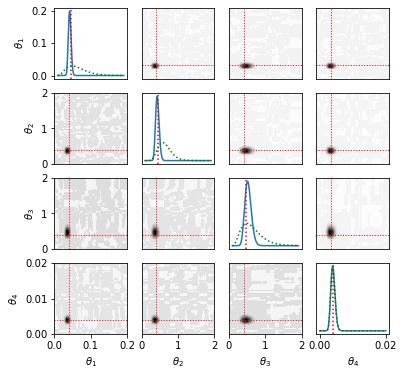

In [15]:
plt.figure(figsize = [6,6])

k = 0
for i in range(4):
    for j in range(4):
        k += 1
        if i==j:
            plt.subplot(4, 4, k)
            
            theta = np.linspace(param_range[i][0],param_range[i][1],1000)
            pr = prior.marginal([k for k in range(4) if i!=k])[theta].numpy()
            po = posterior_pdf.marginal([k for k in range(4) if i!=k])[theta].numpy()
           
            plt.plot(theta,po/np.max(po)*np.max(theta))
            plt.axvline(rates[i],c='r',linestyle=':')
            plt.plot(theta,pr/np.max(po)*np.max(theta),'g:')
            
        else:
            plt.subplot(4, 4, k)
             
            if j<i: 
                theta1 = np.linspace(param_range[j][0],param_range[j][1],127)
                theta2 = np.linspace(param_range[i][0],param_range[i][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T
                plt.contourf(T1, T2, po, cmap='gray_r', levels =12)
                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
            else: 
                theta1 = np.linspace(param_range[i][0],param_range[i][1],127)
                theta2 = np.linspace(param_range[j][0],param_range[j][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T
                plt.contourf(T2, T1, po, cmap='gray_r', levels =32)
                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
        
        if i==3: plt.xlabel(r'$\theta_'+str(j+1)+'$')
        if j==0: plt.ylabel(r'$\theta_'+str(i+1)+'$')
        
        if j>0: plt.yticks([])
        if i<3: plt.xticks([])

plt.savefig('seiqr_post.eps')